In [2]:
import os
from pathlib import Path
from collections import Counter

import anndata
import scanpy as sc
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import pollock
from pollock.models.model import PollockDataset, PollockModel, load_from_directory

In [5]:
output_dir = '/home/estorrs/data/outputs/pollock_module_combining_09292020'

figure_dir = os.path.join(output_dir, 'figures')
data_dir = os.path.join(output_dir, 'data')

Path(figure_dir).mkdir(parents=True, exist_ok=True)
Path(data_dir).mkdir(parents=True, exist_ok=True)

In [6]:
!wget http://cf.10xgenomics.com/samples/cell-exp/1.1.0/pbmc3k/pbmc3k_filtered_gene_bc_matrices.tar.gz -O /home/estorrs/data/outputs/pollock_module_combining_09292020/data/pbmc3k_filtered_gene_bc_matrices.tar.gz
# !cd data; tar -xzf pbmc3k_filtered_gene_bc_matrices.tar.gz

--2020-09-29 14:51:03--  http://cf.10xgenomics.com/samples/cell-exp/1.1.0/pbmc3k/pbmc3k_filtered_gene_bc_matrices.tar.gz
Resolving cf.10xgenomics.com (cf.10xgenomics.com)... 104.18.0.173, 104.18.1.173, 2606:4700::6812:ad, ...
Connecting to cf.10xgenomics.com (cf.10xgenomics.com)|104.18.0.173|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://cf.10xgenomics.com/samples/cell-exp/1.1.0/pbmc3k/pbmc3k_filtered_gene_bc_matrices.tar.gz [following]
--2020-09-29 14:51:03--  https://cf.10xgenomics.com/samples/cell-exp/1.1.0/pbmc3k/pbmc3k_filtered_gene_bc_matrices.tar.gz
Connecting to cf.10xgenomics.com (cf.10xgenomics.com)|104.18.0.173|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 7621991 (7.3M) [application/x-tar]
Saving to: ‘/home/estorrs/data/outputs/pollock_module_combining_09292020/data/pbmc3k_filtered_gene_bc_matrices.tar.gz’

/home/estorrs/data/ 100%[===================>]   7.27M  --.-KB/s    in 0.1s    

2020-09-2

read in the 10x scRNA-seq data with scanpy

In [9]:
adata = sc.read_10x_mtx('/home/estorrs/data/outputs/pollock_module_combining_09292020/data/filtered_gene_bc_matrices/hg19',
                        var_names='gene_symbols')
adata.var_names_make_unique()
adata

AnnData object with n_obs × n_vars = 2700 × 32738
    var: 'gene_ids'

In [10]:
adata.layers['raw_counts'] = adata.X.copy()

In [11]:
sc.pp.filter_cells(adata, min_genes=200)
sc.pp.filter_genes(adata, min_cells=3)

adata.var['mt'] = adata.var_names.str.startswith('MT-')  # annotate the group of mitochondrial genes as 'mt'
sc.pp.calculate_qc_metrics(adata, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)

adata = adata[adata.obs.n_genes_by_counts < 2500, :]
adata = adata[adata.obs.pct_counts_mt < 5, :]

sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)
sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5)

adata.raw = adata

/home/estorrs/miniconda3/envs/pollock_v2/lib/python3.7/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):
/home/estorrs/miniconda3/envs/pollock_v2/lib/python3.7/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):
/home/estorrs/miniconda3/envs/pollock_v2/lib/python3.7/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):
/home/estorrs/miniconda3/envs/pollock_v2/lib/python3.7/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_c

In [12]:
adata = adata[:, adata.var.highly_variable]

sc.pp.regress_out(adata, ['total_counts', 'pct_counts_mt'])

sc.pp.scale(adata, max_value=10)

/home/estorrs/miniconda3/envs/pollock_v2/lib/python3.7/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):
/home/estorrs/miniconda3/envs/pollock_v2/lib/python3.7/site-packages/anndata/_core/anndata.py:1192: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if is_string_dtype(df[key]) and not is_categorical(df[key])


In [13]:
sc.tl.pca(adata, svd_solver='arpack')
sc.pp.neighbors(adata, n_neighbors=10, n_pcs=40)
sc.tl.umap(adata)

/home/estorrs/miniconda3/envs/pollock_v2/lib/python3.7/site-packages/anndata/_core/anndata.py:1192: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if is_string_dtype(df[key]) and not is_categorical(df[key])


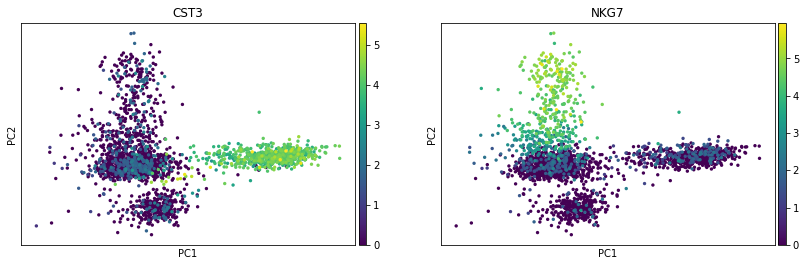

In [14]:
sc.pl.pca(adata, color=['CST3', 'NKG7'])

if you have not installed the leidenalg library yet, you will need to install it by uncommenting and running the following cell

In [23]:
# !pip3 install leidenalg

/home/estorrs/miniconda3/envs/pollock_v2/lib/python3.7/site-packages/anndata/_core/anndata.py:1192: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if is_string_dtype(df[key]) and not is_categorical(df[key])


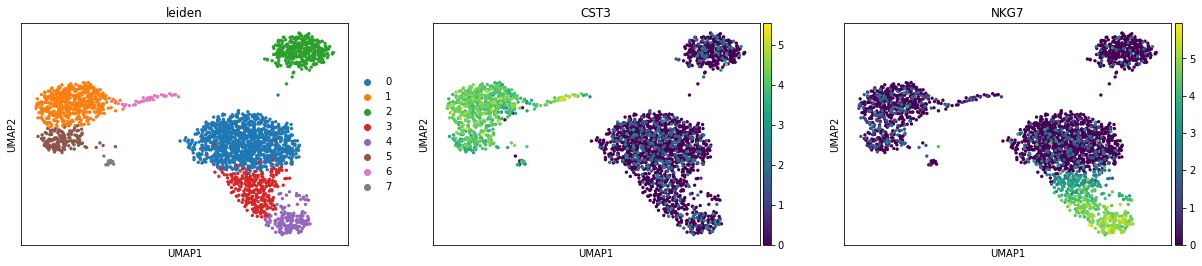

In [22]:
sc.tl.leiden(adata)
sc.pl.umap(adata, color=['leiden', 'CST3', 'NKG7'])


In [24]:
marker_genes = ['IL7R', 'CD79A', 'MS4A1', 'CD8A', 'CD8B', 'LYZ', 'CD14',
                'LGALS3', 'S100A8', 'GNLY', 'NKG7', 'KLRB1',
                'FCGR3A', 'MS4A7', 'FCER1A', 'CST3', 'PPBP']

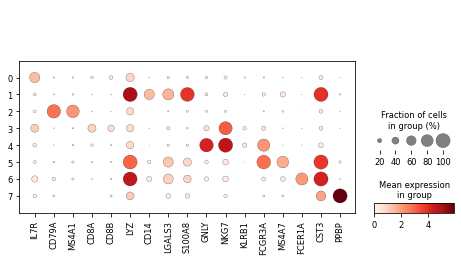

In [25]:
sc.pl.dotplot(adata, marker_genes, groupby='leiden')

In [26]:
new_cluster_names = [
    'CD4 T', 'CD14 Monocytes',
    'B', 'CD8 T',
    'NK', 'FCGR3A Monocytes',
    'Dendritic', 'Megakaryocytes']
adata.rename_categories('leiden', new_cluster_names)

/home/estorrs/miniconda3/envs/pollock_v2/lib/python3.7/site-packages/anndata/_core/anndata.py:1192: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if is_string_dtype(df[key]) and not is_categorical(df[key])


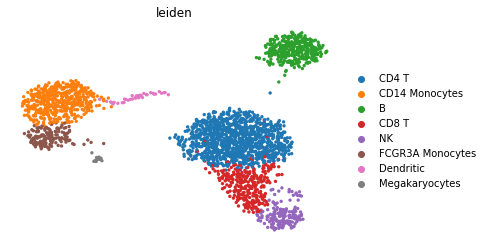

In [27]:
sc.pl.umap(adata, color='leiden', frameon=False)

save the anndata object for later

In [28]:
adata.write_h5ad(os.path.join(data_dir, 'pbmc.h5ad'))

/home/estorrs/miniconda3/envs/pollock_v2/lib/python3.7/site-packages/anndata/_core/anndata.py:1192: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if is_string_dtype(df[key]) and not is_categorical(df[key])


## 3. train pollock module

specify a location to save the trained pollock module

In [64]:
adata = sc.read_h5ad(os.path.join(data_dir, 'pbmc.h5ad'))

In [65]:
module_save_filepath = os.path.join(data_dir, 'pbmc_base')
Path(module_save_filepath).mkdir(parents=True, exist_ok=True)

here we create a new anndata object from our processed anndata object

scanpy expects the raw counts data to be in the X attribute

In [66]:
train_adata = anndata.AnnData(X=adata.layers['raw_counts'],
                             obs=adata.obs,
                             var=adata.var)
train_adata

AnnData object with n_obs × n_vars = 2638 × 1838
    obs: 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'leiden'
    var: 'gene_ids', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'

take a look at our cell counts

In [67]:
Counter(train_adata.obs['leiden']).most_common()

[('CD4 T', 1139),
 ('CD14 Monocytes', 484),
 ('B', 341),
 ('CD8 T', 310),
 ('NK', 163),
 ('FCGR3A Monocytes', 150),
 ('Dendritic', 38),
 ('Megakaryocytes', 13)]

initialize PollockDataset
  
  - cell_type_key
    - key in .obs where the cell type label is stored
  - n_per_cell_type
    - number of cells per cell type that should be included in the training dataset. For smaller datasets like this one 200 is usually sufficient. For larger datasets it can be helpful to increase the number of cells to 500-2k range. If you have a particular cell type in your dataset that has a low cell count it is usually a good idea not to increase n_per_cell_type too much. A good rule of thumb is that n_per_cell_type should be no greater than the minimum cell type count * 10
  - oversample
    - if true, then cell types in the training dataset are oversampled so each cell type has n_per_cell_type cells

In [68]:
pds = PollockDataset(train_adata, cell_type_key='leiden', n_per_cell_type=200,
                    oversample=True, dataset_type='training')

2020-09-29 15:17:07,060 normalizing counts for model training
2020-09-29 15:17:07,074 scaling data
2020-09-29 15:17:07,102 creating tf datasets
/home/estorrs/miniconda3/envs/pollock_v2/lib/python3.7/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):


 create pollock model
    
  - alpha
    - this parameter controls how regularized the BVAE is. .0001 is usually a good value. If you increase alpha the cell embeddings are typically more noisy, but also more generalizable. If you decrease alpha the cell embeddings are typically less noisy, but also less generalizable.
  - latent_dim
    - the shape of the latent dim in the BVAE. In general 25 is a good starting point. This number is analgous to the number of principle components in a traditional pca decomposition.

In [69]:
pm = PollockModel(pds.cell_types, pds.train_adata.shape[1], alpha=.001, latent_dim=25)

  - epochs
    - the number of epochs the neural net should train for. typically between 25-50, but can vary based on alpha and latent_dim. Usually it's a good idea to train for too many epochs, and then look at the model performance and train again with the optimal number of epochs as we do here in this tutorial

In [70]:
pm.fit(pds, epochs=30)

/home/estorrs/miniconda3/envs/pollock_v2/lib/python3.7/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):


2020-09-29 15:17:09,481 5 out of the last 14 calls to <function compute_loss at 0x7f3d3e329cb0> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings is likely due to passing python objects instead of tensors. Also, tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. Please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for more details.
/home/estorrs/miniconda3/envs/pollock_v2/lib/python3.7/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):
2020-09-29 15:17:09,927 epoch: 1, train loss: 6.977012634277344, val loss: 5.8072967529296875
/home/estorrs/miniconda3/envs/pollock_v2/lib/python3.7/site-packages/anndata/_core/anndata.py:1094

/home/estorrs/miniconda3/envs/pollock_v2/lib/python3.7/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):
2020-09-29 15:17:23,276 epoch: 14, train loss: 4.295238494873047, val loss: 3.782085418701172
/home/estorrs/miniconda3/envs/pollock_v2/lib/python3.7/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):
/home/estorrs/miniconda3/envs/pollock_v2/lib/python3.7/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):
2020-09-29 15:17:24,245 epoch: 15, train loss: 4.305759906768799, val loss: 3.765270709991455
/home/estorrs/miniconda3/envs/pollock_v2/lib

/home/estorrs/miniconda3/envs/pollock_v2/lib/python3.7/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):
/home/estorrs/miniconda3/envs/pollock_v2/lib/python3.7/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):
2020-09-29 15:17:37,022 epoch: 28, train loss: 4.011014938354492, val loss: 3.6379966735839844
/home/estorrs/miniconda3/envs/pollock_v2/lib/python3.7/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):
/home/estorrs/miniconda3/envs/pollock_v2/lib/python3.7/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is depr

save module to the given filepath

In [71]:
pm.save(pds, module_save_filepath)

/home/estorrs/miniconda3/envs/pollock_v2/lib/python3.7/site-packages/numpy/lib/format.py:350: UserWarning: metadata on a dtype may be saved or ignored, but will raise if saved when read. Use another form of storage.
  d['descr'] = dtype_to_descr(array.dtype)


Text(32.99999999999999, 0.5, 'Groundtruth')

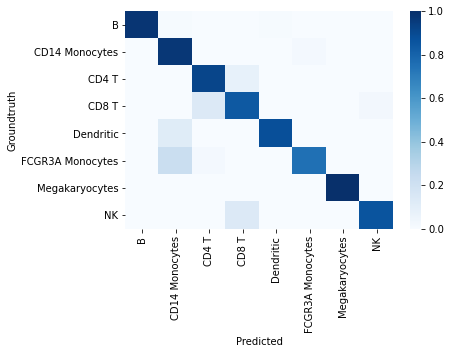

In [72]:
confusion_matrix = pd.DataFrame(data=pm.summary['validation']['confusion_matrix'], columns=pm.class_names,
                  index=pm.class_names)
sns.heatmap(confusion_matrix, cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Groundtruth')

In [73]:
# adata = 

In [74]:
prediction_adata = anndata.AnnData(X=adata.layers['raw_counts'].copy(),
                                  obs=adata.obs,
                                  var=adata.var)
loaded_pds, loaded_pm = load_from_directory(prediction_adata, module_save_filepath)

2020-09-29 15:17:40,434 normalizing counts for prediction
2020-09-29 15:17:40,435 filtering for genes in training set
2020-09-29 15:17:40,437 0 genes in training set are missing from prediction set
/home/estorrs/miniconda3/envs/pollock_v2/lib/python3.7/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):
/home/estorrs/miniconda3/envs/pollock_v2/lib/python3.7/site-packages/scanpy/preprocessing/_simple.py:339: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)
2020-09-29 15:17:40,476 scaling data


In [75]:
labels, probs, cell_type_probs = loaded_pm.predict_pollock_dataset(loaded_pds, labels=True, )

df = pd.DataFrame.from_dict({
    'predicted_cell_type': labels,
    'cell_type_probability': probs,
})
df.index = prediction_adata.obs.index
df = pd.concat((df, pd.DataFrame(data=cell_type_probs, index=prediction_adata.obs.index,
                            columns=[f'probability_{c}' for c in loaded_pds.cell_types])), axis=1)
adata.obs = pd.merge(adata.obs, df, left_index=True, right_index=True)
adata.obs['annotated_cell_type'] = adata.obs['leiden'].to_list()

/home/estorrs/miniconda3/envs/pollock_v2/lib/python3.7/site-packages/anndata/_core/anndata.py:1192: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if is_string_dtype(df[key]) and not is_categorical(df[key])
... storing 'predicted_cell_type' as categorical
... storing 'annotated_cell_type' as categorical


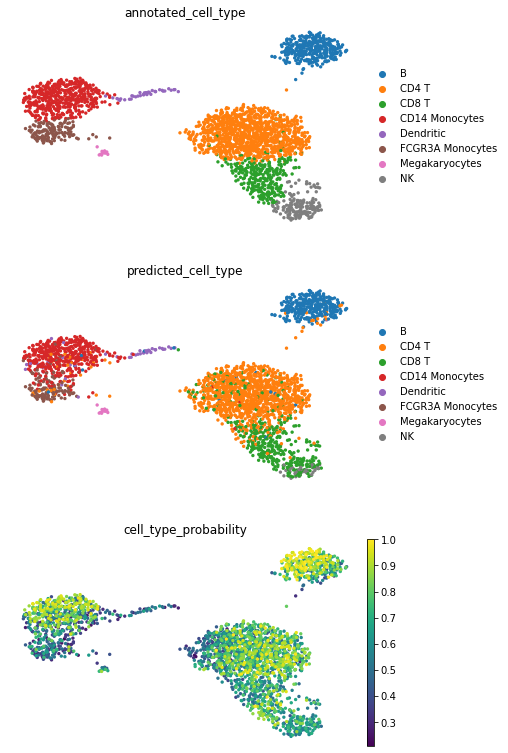

In [76]:
sc.pl.umap(adata, color=['annotated_cell_type', 'predicted_cell_type', 'cell_type_probability'],
          frameon=False, ncols=1)

In [77]:
cell_embeddings = loaded_pm.get_cell_embeddings(loaded_pds.prediction_ds)
cell_embeddings.shape, cell_embeddings

((2638, 25),
 array([[ 0.2550596 ,  0.3025626 , -0.7124712 , ...,  0.03651757,
         -0.5156606 , -0.3502481 ],
        [ 1.1277913 ,  0.9684224 , -1.2300416 , ...,  0.7179092 ,
         -1.0456077 , -1.3635439 ],
        [ 0.74846923,  0.77497363, -0.27565378, ...,  0.08104961,
         -0.7746118 , -0.78131753],
        ...,
        [ 0.29276395,  0.22550334, -0.68723357, ...,  0.34715325,
         -0.4624899 , -0.6842631 ],
        [ 0.33338022,  0.0548504 , -0.6393866 , ...,  0.54601777,
          0.39102483, -0.2515126 ],
        [ 0.33928668,  0.77105844,  0.19892609, ..., -0.04364269,
         -0.4031933 , -0.8563091 ]], dtype=float32))

In [78]:
adata.obsm['cell_embeddings'] = cell_embeddings
sc.pp.neighbors(adata, use_rep='cell_embeddings')
sc.tl.umap(adata)

/home/estorrs/miniconda3/envs/pollock_v2/lib/python3.7/site-packages/anndata/_core/anndata.py:1192: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if is_string_dtype(df[key]) and not is_categorical(df[key])


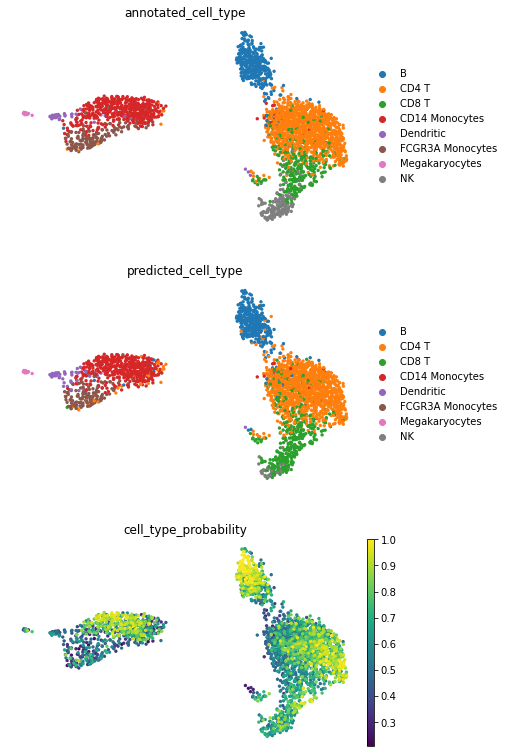

In [79]:
sc.pl.umap(adata, color=['annotated_cell_type', 'predicted_cell_type', 'cell_type_probability'],
          frameon=False, ncols=1)